<a href="https://colab.research.google.com/github/Eggathin/potential-enigma/blob/main/STA365_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
url = 'https://github.com/Eggathin/potential-enigma/blob/main/test.csv?raw=true'
df = pd.read_csv(url)
df.describe()

,x,y
count,300.000000,300.000000
mean,50.936667,51.205051
std,28.504286,29.071481
min,0.000000,-3.467884
25%,27.000000,25.676502
50%,53.000000,52.170557
75%,73.000000,74.303007
max,100.000000,105.591837


In [ ]:
n,p=100,10; X,y=np.zeros((n,p)),np.ones((n,1))

size = 300
X = np.random.randn(size)

# Replace this made up data with your data set from kaggle...
with pm.Model() as MLR:
  # Empirical Bayes prior
  beta = pm.Normal('b', mu=50, sigma=28)
  mu = beta * X
  sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0)
  y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['y'])
with MLR:
  idata = pm.sample()

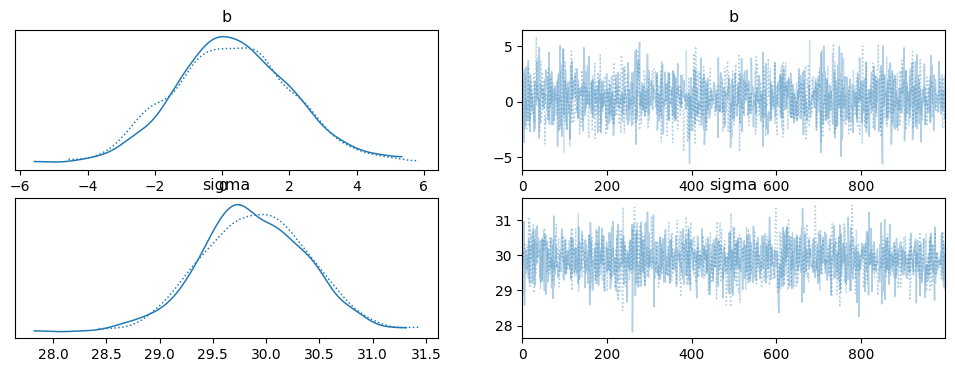

In [ ]:
az.plot_trace(idata)
plt.show()

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

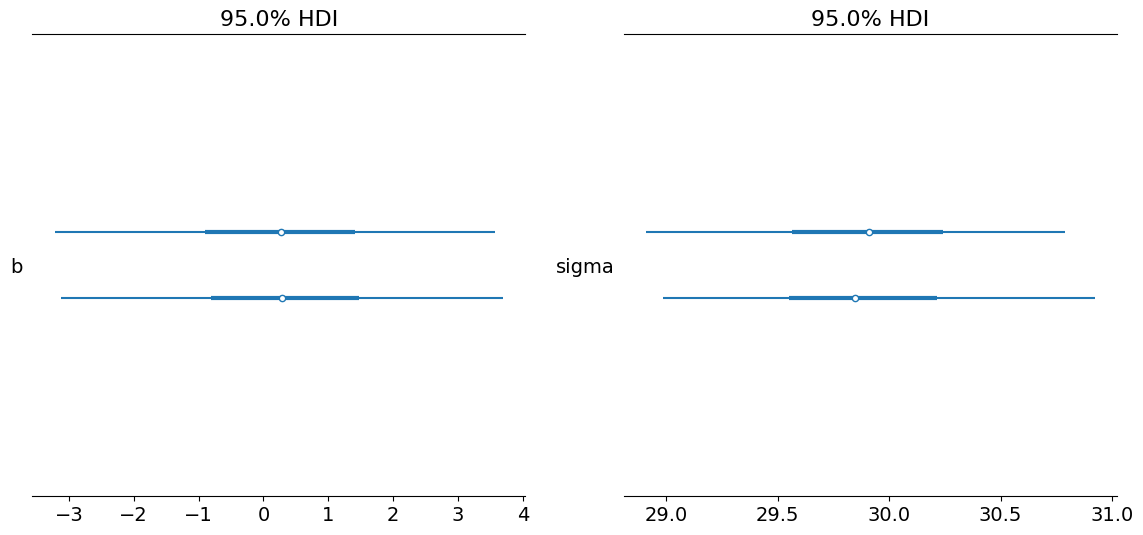

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,6))
az.plot_forest(idata, var_names=["b"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(idata, var_names=["sigma"], combined=False, hdi_prob=0.95, ax=ax[1])

In [ ]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.32,1.76,-2.78,3.73,0.04,0.04,2035.80,1398.54,1.0
sigma,29.89,0.49,28.97,30.81,0.01,0.01,1888.44,1195.35,1.0


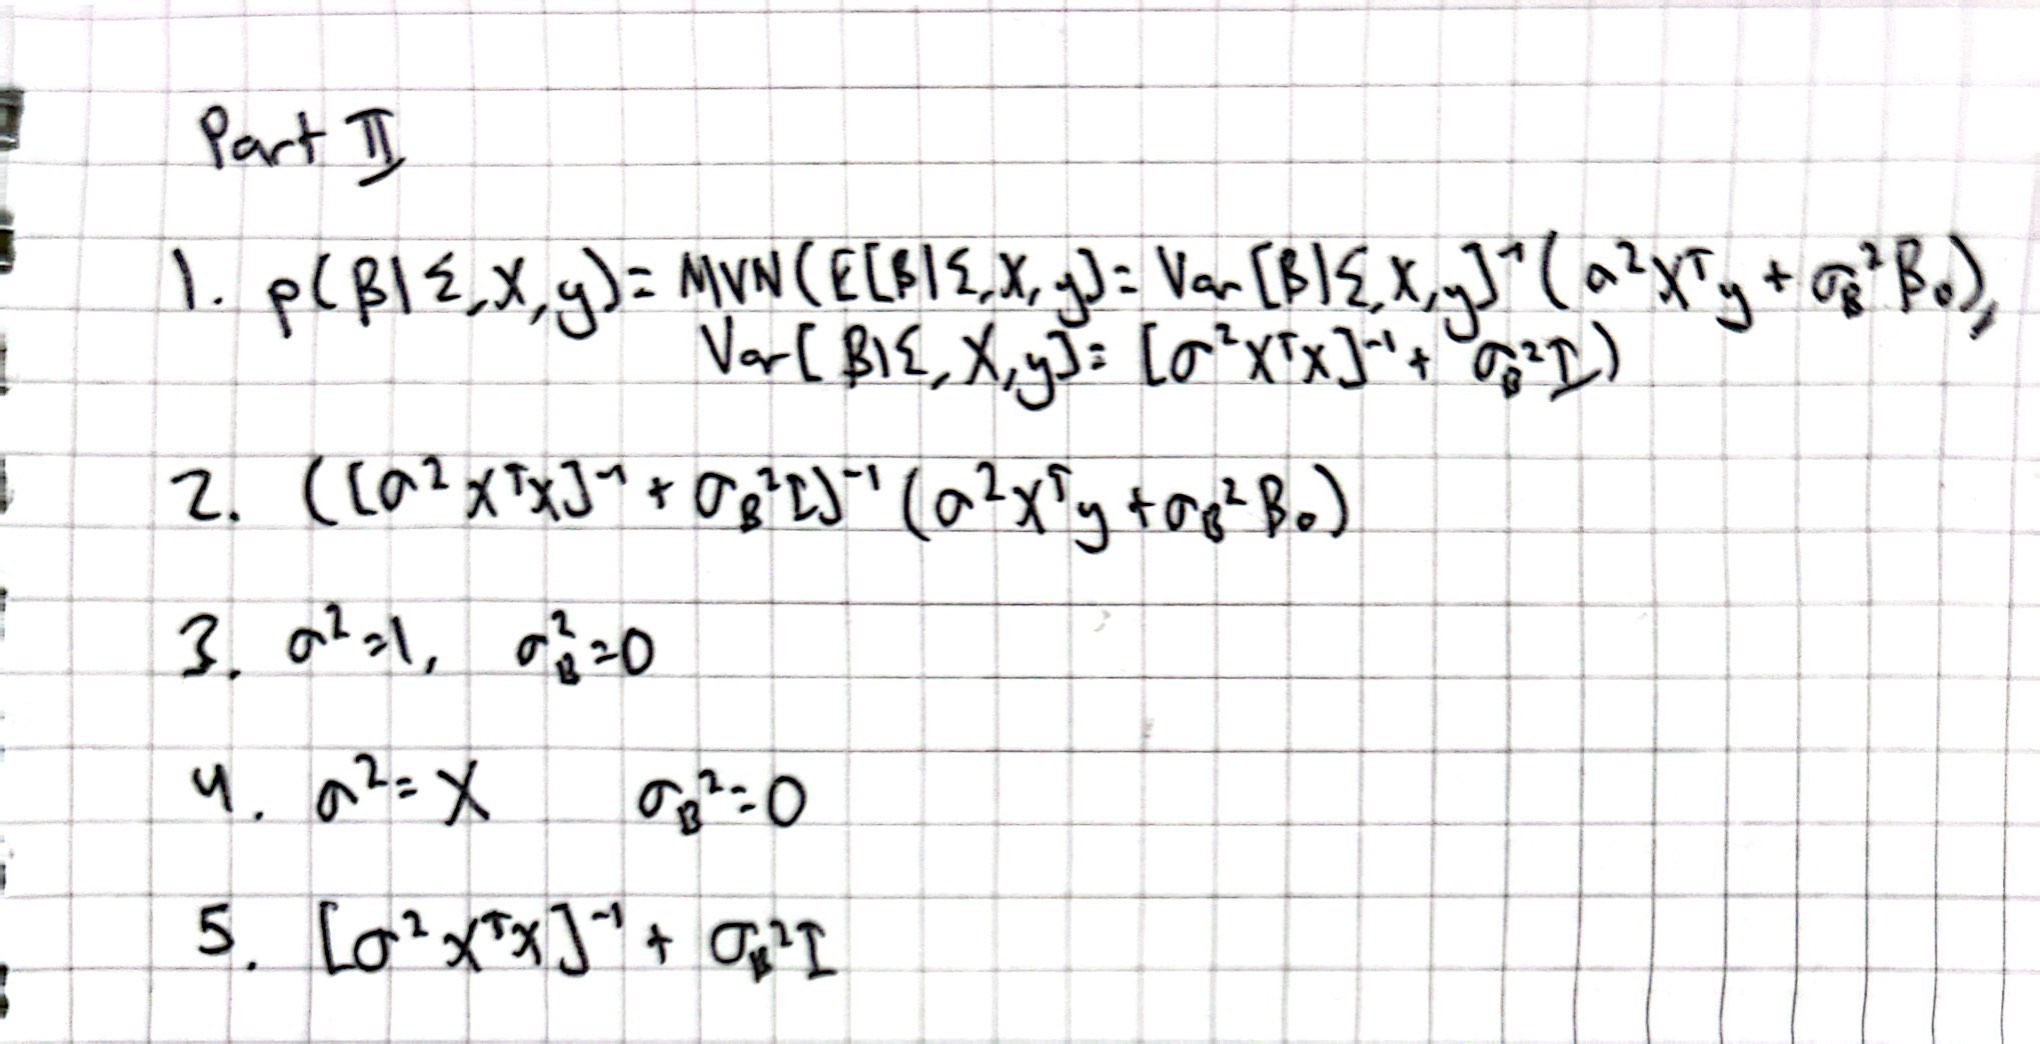

In [46]:
url = 'https://github.com/Eggathin/potential-enigma/blob/main/mktmix.csv?raw=true'
df = pd.read_csv(url)
df.describe()

,NewVolSales,Base_Price,Radio,InStore,Discount,TV,Stout
count,100.0000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,20218.7500,15.283760,256.690000,32.484930,0.020784,140.263094,2.539881
std,1580.1606,0.523781,86.994682,13.671751,0.027401,43.532810,0.313435
min,17431.0000,13.735724,0.000000,10.782000,0.000000,37.656174,1.818600
25%,19111.5000,15.029276,235.000000,21.890000,0.000000,113.899371,2.308642
50%,19966.5000,15.332887,278.500000,30.170500,0.000000,138.036686,2.478595
75%,20960.2500,15.642632,313.250000,40.167750,0.048585,175.681780,2.814315
max,24944.0000,16.281020,399.000000,68.119000,0.090763,240.291967,3.158620


In [66]:
y_obs = df.values
p=7

with pm.Model() as MNV_LKJ:
  packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta=2.0,
                               sd_dist=pm.HalfCauchy.dist(beta=2.5, shape=p*(p-1)//2), compute_corr=False)
  L = pm.expand_packed_triangular(p, packed_L)
  Sigma = pm.Deterministic('Sigma', L)
  mu = pm.MvNormal('mu', mu=np.zeros(p), cov=np.eye(p), shape=p)
  y = pm.MvNormal('y', mu=mu, chol=Sigma, observed=y_obs[0])
with MNV_LKJ:
  idata = pm.sample()

/usr/local/lib/python3.10/dist-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


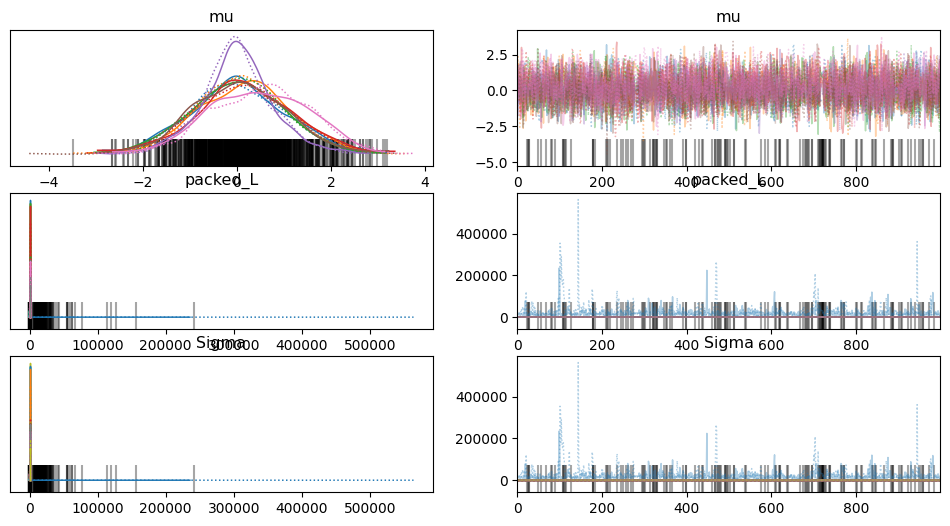

In [67]:
az.plot_trace(idata)
plt.show()